# Importing datasets, cleaning and initial statistical description

## 1. SETUP AND IMPORTS

### Libraries

In [90]:
# Essential libraries for data analysis
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import os
import numpy as np
from itertools import product
from matplotlib.colors import Normalize # Needed for normalize colors
from matplotlib.cm import ScalarMappable # Needed for color maps
from matplotlib.animation import FuncAnimation

### Function definition

In [91]:

# Spatial join to find administrative boundaries for each point
def find_admin_boundaries(coordinates_gdf, boundaries_gdf):
    """
    Find the administrative boundary for each point.
    :param coordinates_gdf: GeoDataFrame with Point geometries.
    :param boundaries_gdf: GeoDataFrame with Polygon geometries.
    :return: GeoDataFrame with matched administrative boundaries.
    """
    # Ensure the same CRS
    if coordinates_gdf.crs != boundaries_gdf.crs:
        boundaries_gdf = boundaries_gdf.to_crs(coordinates_gdf.crs)
    
    # Perform spatial join
    joined = gpd.sjoin(coordinates_gdf, boundaries_gdf, how="left", predicate="within")
    return joined


def w_avg(df, values, weights):
    """
    Calculate weighted average of a DataFrame column using specified weights.
    
    Args:
        df: DataFrame containing values and weights columns
        values: Name of column containing values to average
        weights: Name of column containing weights
    
    Returns:
        float: Weighted average
    """
    d = df[values]
    w = df[weights]
    return (d * w).sum() * 100 / w.sum()

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=ndhs_df[indices_non_na].loc[x.index, "kid_weight"])

def weighted_mean(values, weights):
    """Calculate the weighted mean of a series."""
    return np.average(values, weights=weights)


## 2. DATA LOADING

### Subnational Administrative Boundaries (adm2)

In [92]:
# Load administrative boundaries
admin_boundaries = gpd.read_file("./input/data/geoBoundaries-NGA-ADM2-all/geoBoundaries-NGA-ADM2.shp")

### DHS data

In [93]:
# Importing data 
## Load individual dataset
ndhs_df = pd.read_csv("./output/data/ndhs/df_NDHS1990_2018.csv")
## Load cluster coordinates and convert to geodataframe
ndhs_coordinate = pd.read_excel("./input/data/ndhs/ngaDhsShapefileRaw.xlsx")
ndhs_coordinate = gpd.GeoDataFrame(ndhs_coordinate,geometry=gpd.points_from_xy(ndhs_coordinate['LONGNUM'], ndhs_coordinate['LATNUM']),crs="EPSG:4326")  # WGS 84 coordinate system

### MICS data

In [128]:
# Importing data 
## Load individual dataset
mics_df_2017 = pd.read_spss('./input/data/mics/Nigeria 2016-2017 MICS5_Datasets/Nigeria MICS5 Datasets/Nigeria MICS 2016-17 SPSS Datasets/ch.sav')

## Load cluster coordinates and convert to geodataframe
#mics_df_2007_coordinate =  gpd.read_file("./input/data/mics/Nigeria 2007 MICS_Datasets/NigeriaMICS2016-17Boundaries_1/Shapefiles/mics_boundaries3.shp")

In [132]:
# Pre processing data

## 2017
mics_df_2017 = mics_df_2017[['HH1', 'HH2', 'UF1', 'UF2', 'HAZ2', 'HAZFLAG', 'chweight', 'chweightkano', 'chweightlagos']]

mics_df_2017.rename(columns={'HH1': 'cluster_nbr_1', 'HH2': 'hh_nbr_1', 'UF1': 'cluster_nbr_2', 'UF2': 'hh_nubr_2','HAZ2': 'haz_who', 
                            'HAZFLAG': 'is_na_haz_who', 'chweight' : 'kid_weight'}, inplace=True)


## 3. DATA CLEANING


### 3.1 Missing Values

#### NDHS

In [94]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(ndhs_df.isna().sum()/ndhs_df.isna().count()*100,2),'Nbr of Missing Values':ndhs_df.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
haz_who,40.74,45442
kid_weight,3.18,3552
dhsid,0.00,0
survey,0.00,0
survey_year,0.00,0
data_source,0.00,0
is_na_haz,0.00,0


#### MICS

In [ ]:
# Missing values MICS 2017
pd.DataFrame(data={'% of Missing Values':round(mics_df_2017.isna().sum()/mics_df_2017.isna().count()*100,2),'Nbr of Missing Values':mics_df_2017.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
haz_who,40.74,45442
kid_weight,3.18,3552
dhsid,0.00,0
survey,0.00,0
survey_year,0.00,0
data_source,0.00,0
is_na_haz,0.00,0


### 3.2 Data Types

### 3.3 Duplicates

### 3.4 Feature Engineering

#### NDHS

In [ ]:
# Merging DHS spatial data with shapefile to create the adm2 level database
ndhs_merged = find_admin_boundaries(ndhs_coordinate, admin_boundaries)

# merging to the dhs dataset
ndhs_df = ndhs_df.merge(ndhs_merged, left_on="dhsid", right_on="DHSID", how="outer")

# Computing the undernutrition rates
ndhs_df["stunted"] = ndhs_df["haz_who"].apply(lambda row: 1 if row < -2 else np.nan if np.isnan(row) else 0)


# Grouping to compute the average undernutrition rates
# Filter the data first
indices_non_na = ~np.isnan(ndhs_df["haz_who"])
indices_non_na

# Perform the groupby operation
ndhs_df = ndhs_df[indices_non_na].groupby(["survey_year", "shapeID"]).apply(
    lambda group: pd.Series({
        "total_weight": group["kid_weight"].sum(),
        "stunting_rate": weighted_mean(group["stunted"], group["kid_weight"])
    })
).reset_index()

# Compute stunting rate by year
stunting_year = ndhs_df[indices_non_na].groupby(["survey_year"]).apply(
    lambda group: pd.Series({
        "stunting_rate": weighted_mean(group["stunting_rate"]*100, group["total_weight"])
    })
).reset_index()

stunting_year = stunting_year.sort_values(by="survey_year", ascending=True)

# Merging with all the possibles shapeID to complete the dataset
ndhs_df = pd.DataFrame(
    list(
        product((ndhs_df['survey_year'].unique()).tolist(), (ndhs_df['shapeID'].unique()).tolist())), 
        columns=['survey_year', 'shapeID']).merge(ndhs_df, on=["shapeID","survey_year"], how="left")

# merging the dhs dataset to the shapefile
ndhs_df = ndhs_df.merge(admin_boundaries[["shapeName","shapeID","geometry"]], left_on="shapeID", right_on="shapeID", how="outer")


#### MICS

In [ ]:

path_mora["Grade"] = np.where(path_mora["NEWDELHI GRADE"] == "D", "Depression (17<= W <28)",
                        np.where(path_mora["NEWDELHI GRADE"] == "DD", "Deep Depression (28<= W <34)",
                                np.where(path_mora["NEWDELHI GRADE"] == "CS", "Cyclonic Storm (34<= W <48)",
                                        np.where(path_mora["NEWDELHI GRADE"] == "SCS", "Severe Cyclonic Storm (48<= W <64)",
                                                np.where(path_mora["NEWDELHI GRADE"] == "VSCS", "Very Severe Cyclonic Storm (64<= W <120)",
                                                        np.where(path_mora["NEWDELHI GRADE"] == "SCS", "Super Cyclonic Storm (W >=120)", "No defini"))))))


# # Merging DHS spatial data with shapefile to create the adm2 level database
# ndhs_merged = find_admin_boundaries(ndhs_coordinate, admin_boundaries)

# # merging to the dhs dataset
# ndhs_df = ndhs_df.merge(ndhs_merged, left_on="dhsid", right_on="DHSID", how="outer")

# # Computing the undernutrition rates
# ndhs_df["stunted"] = ndhs_df["haz_who"].apply(lambda row: 1 if row < -2 else np.nan if np.isnan(row) else 0)


# # Grouping to compute the average undernutrition rates
# # Filter the data first
# indices_non_na = ~np.isnan(ndhs_df["haz_who"])
# indices_non_na

# # Perform the groupby operation
# ndhs_df = ndhs_df[indices_non_na].groupby(["survey_year", "shapeID"]).apply(
#     lambda group: pd.Series({
#         "total_weight": group["kid_weight"].sum(),
#         "stunting_rate": weighted_mean(group["stunted"], group["kid_weight"])
#     })
# ).reset_index()

# # Compute stunting rate by year
# stunting_year = ndhs_df[indices_non_na].groupby(["survey_year"]).apply(
#     lambda group: pd.Series({
#         "stunting_rate": weighted_mean(group["stunting_rate"]*100, group["total_weight"])
#     })
# ).reset_index()

# stunting_year = stunting_year.sort_values(by="survey_year", ascending=True)

# # Merging with all the possibles shapeID to complete the dataset
# ndhs_df = pd.DataFrame(
#     list(
#         product((ndhs_df['survey_year'].unique()).tolist(), (ndhs_df['shapeID'].unique()).tolist())), 
#         columns=['survey_year', 'shapeID']).merge(ndhs_df, on=["shapeID","survey_year"], how="left")

# # merging the dhs dataset to the shapefile
# ndhs_df = ndhs_df.merge(admin_boundaries[["shapeName","shapeID","geometry"]], left_on="shapeID", right_on="shapeID", how="outer")


### 3.5 Data Visualization

#### NDHS

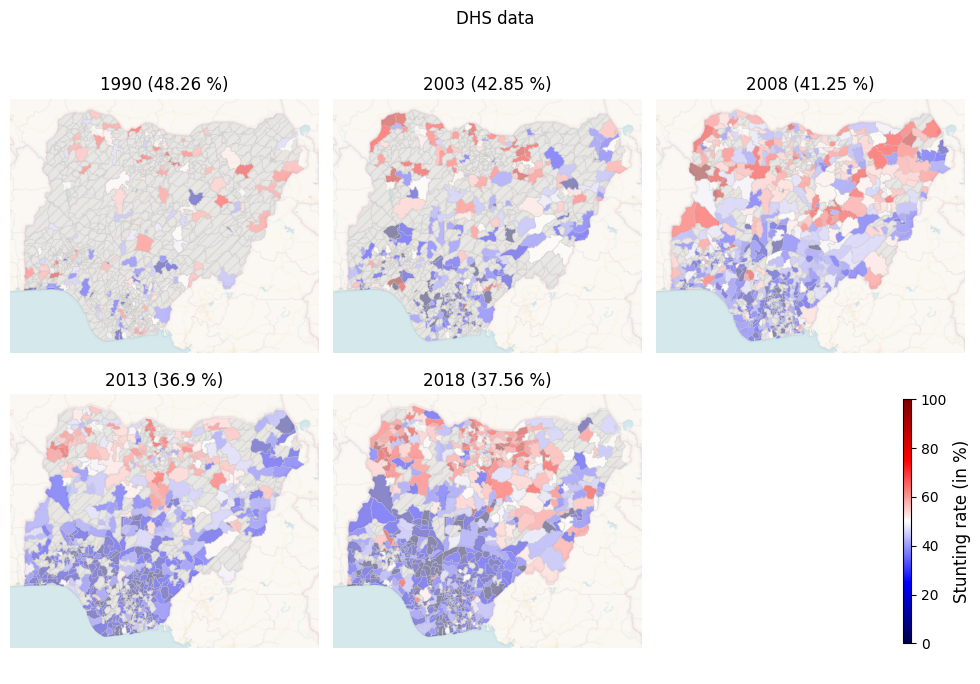

In [ ]:
# Static plot
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(10,7))

# Setting a common title
fig.text(0.5, 0.95, "DHS data", ha="center", fontsize=12)

# Plotting , missing_kwds={"color": "lightgrey","edgecolor": "darkred","hatch": "///","label": "No data"}, cmap=plt.colormaps['Greys'].resampled(5), edgecolor='0.8', legend=True, legend_kwds={"loc": "lower left",  'markerscale':1.29, 'title':'(a). stunting rate','title_fontsize':'medium', 'fontsize':'small'}
gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"]==1990], crs="EPSG:4326").plot(ax=ax0, lw=0.5, alpha=0.45, column="stunting_rate", categorical=False,   missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},cmap="seismic", vmin=0, vmax=1,edgecolor="0.8",legend=False)
gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"]==2003], crs="EPSG:4326").plot(ax=ax1, lw=0.5, alpha=0.45, column="stunting_rate", categorical=False,  missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},cmap="seismic", vmin=0, vmax=1,edgecolor="0.8",legend=False)
gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"]==2008], crs="EPSG:4326").plot(ax=ax2, lw=0.5, alpha=0.45, column="stunting_rate", categorical=False,  missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},cmap="seismic", vmin=0, vmax=1,edgecolor="0.8",legend=False)
gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"]==2013], crs="EPSG:4326").plot(ax=ax3, lw=0.5, alpha=0.45, column="stunting_rate", categorical=False,  missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},cmap="seismic", vmin=0, vmax=1,edgecolor="0.8",legend=False)
gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"]==2018], crs="EPSG:4326").plot(ax=ax4, lw=0.5, alpha=0.45, column="stunting_rate", categorical=False,   missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},cmap="seismic", vmin=0, vmax=1,edgecolor="0.8",legend=False)


# Extract the legend from an axes - used the last axes for the smaller sample data
#leg1 = ax[0].get_legend()



# Add base map
cx.add_basemap(ax0,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax1,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax2,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax3,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax4,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')

# Sans axe 
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

# set facecolor
ax0.set_facecolor("white")
ax1.set_facecolor("white")
ax2.set_facecolor("white")
ax3.set_facecolor("white")
ax4.set_facecolor("white")
ax5.set_facecolor("white")

# Set title and legend title
ax0.title.set_text("1990 (" + str(np.round(stunting_year.loc[0,"stunting_rate"],2)) + " %)")
ax1.title.set_text("2003 (" + str(np.round(stunting_year.loc[1,"stunting_rate"],2)) + " %)")
ax2.title.set_text("2008 (" + str(np.round(stunting_year.loc[2,"stunting_rate"],2)) + " %)")
ax3.title.set_text("2013 (" + str(np.round(stunting_year.loc[3,"stunting_rate"],2)) + " %)")
ax4.title.set_text("2018 (" + str(np.round(stunting_year.loc[4,"stunting_rate"],2)) + " %)")


# Removes ticks and lat/lon labels
ax0.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax1.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax2.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax3.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax4.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)

# Build the color bar
norm = Normalize(vmin=0, vmax=100)
#cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='seismic'), ax=ax, orientation='horizontal', pad=0.05, fraction=0.046, aspect=20, shrink=0.3)
cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap='seismic'), 
    ax=ax5, 
    orientation='vertical',  # Ensure vertical orientation
    pad=0.3,                # Smaller pad to position closer to the axis
    fraction=0.2,            # Increase fraction for a larger vertical span
    aspect=30,               # Adjust aspect ratio for better proportions
    shrink=0.8               # Shrink to control overall size
)

cbar.set_label('Stunting rate (in %)', fontsize=12)

# Adjust subplot spacing for optimal layout
fig.subplots_adjust(wspace=0.01, hspace=0.05)

# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# saving plot
plt.savefig(os.getcwd() + '\\output\\img\\ndhs\\DHS_data_stunting.jpeg', bbox_inches='tight')

In [ ]:
# Dynamic plot

# Filter unique years
unique_years = ndhs_df["survey_year"].sort_values().unique()


# Initialize the GeoDataFrame plot
def initialize_plot():
    ax.set_facecolor("white")
    admin_boundaries.plot(ax=ax, color='white', edgecolor='black') # Empty Canvas
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.set_title('Stunting rate', fontsize=20, pad=10)

    return ax,

def animate(year):
    ax.clear()  # Clear previous plots
    # Filter the data to the current date
    current_data = gpd.GeoDataFrame(ndhs_df[ndhs_df["survey_year"] == pd.to_numeric(year)], crs="EPSG:4326")
    nat_stunting_rate = np.round(stunting_year.loc[stunting_year["survey_year"] == pd.to_numeric(year),"stunting_rate"],2)
    # If you need it as a string:
    nat_stunting_rate = str(nat_stunting_rate.iloc[0])   
    # Plot the current data
    current_data.plot(
        ax=ax,
        lw=0.5,
        alpha=0.45,
        column="stunting_rate",
        categorical=False,   
        missing_kwds={"color": "lightgrey","hatch": "///","label": "No data"},
        cmap="seismic", 
        vmin=0, vmax=1,
        edgecolor="0.8",
        legend=False
    )
    ax.set_title(f"Survey Year: {np.int64(year)}", fontsize=14)
    
    # Restore axes config
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')

    ax.annotate('National Stunting rate',xy=(0,0.15), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=13, 
                    color='grey', weight='bold')
    
    ax.annotate(nat_stunting_rate +' %',xy=(0,0.05), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=20, 
                    color='grey', weight='normal')
    ax.annotate('Data source: Demographic and Health Surveys (DHS)',xy=(1,-0.2), xytext=(0,0), 
                    xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=7, 
                    color='black')
    return ax,


# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 6))

# Build the color bar
norm = Normalize(vmin=0, vmax=100)
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap="seismic"), ax=ax, 
                    orientation='horizontal', pad=0.05, fraction=0.046, 
                    aspect=20, shrink=0.3)

cbar.set_label('Stunting rate (%)', fontsize=12)


ani = FuncAnimation(fig, animate, frames=unique_years, init_func=initialize_plot, blit=False)

# Save the animation or show it
ani.save(os.getcwd() + "\\output\\img\\ndhs\\stunting_rate_animation.gif",  writer='ffmpeg', fps=1, dpi=300)  # Save as GIF

## 4. EXPLORATORY DATA ANALYSIS (EDA)

### 4.1 Statistical Description

#### NDHS

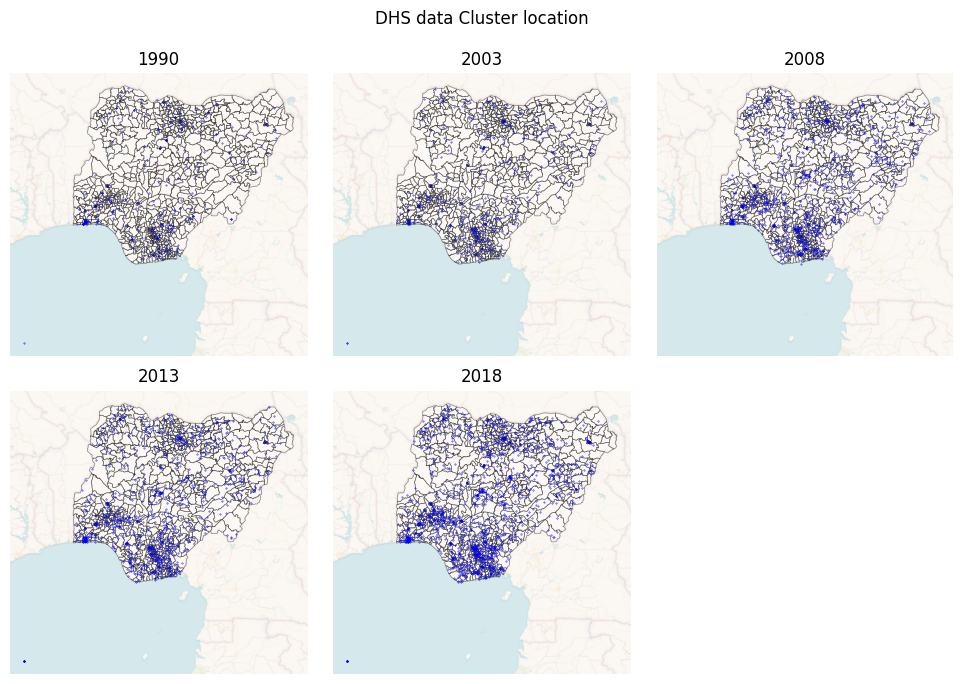

In [ ]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True,figsize=(10,7))

# Setting a common title
fig.text(0.5, 0.95, "DHS Data Cluster Location", ha="center", fontsize=12)

# Plotting
admin_boundaries.to_crs('EPSG:4326').plot(ax=ax0, lw=0.5, alpha=0.45, color="snow", edgecolor='black')
admin_boundaries.to_crs('EPSG:4326').plot(ax=ax1, lw=0.5, alpha=0.45, color="snow", edgecolor='black')
admin_boundaries.to_crs('EPSG:4326').plot(ax=ax2, lw=0.5, alpha=0.45, color="snow", edgecolor='black')
admin_boundaries.to_crs('EPSG:4326').plot(ax=ax3, lw=0.5, alpha=0.45, color="snow", edgecolor='black')
admin_boundaries.to_crs('EPSG:4326').plot(ax=ax4, lw=0.5, alpha=0.45, color="snow", edgecolor='black')

# # Adding the cluster center points
ndhs_coordinate[ndhs_coordinate["DHSYEAR"]==5].plot(ax=ax0, marker='o', color='blue', markersize=0.1, label='Surveyed cluster');
ndhs_coordinate[ndhs_coordinate["DHSYEAR"]==4].plot(ax=ax1, marker='o', color='blue', markersize=0.1, legend=False);
ndhs_coordinate[ndhs_coordinate["DHSYEAR"]==3].plot(ax=ax2, marker='o', color='blue', markersize=0.1, legend=False);
ndhs_coordinate[ndhs_coordinate["DHSYEAR"]==2].plot(ax=ax3, marker='o', color='blue', markersize=0.1, legend=False);
ndhs_coordinate[ndhs_coordinate["DHSYEAR"]==1].plot(ax=ax4, marker='o', color='blue', markersize=0.1, legend=False);

# Extract the legend from an axes - used the last axes for the smaller sample data



# Add base map
cx.add_basemap(ax0,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax1,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax2,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax3,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')
cx.add_basemap(ax4,  source=cx.providers.CartoDB.VoyagerNoLabels, attribution = False, crs='EPSG:4326')

# Sans axe 
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

# set facecolor
ax0.set_facecolor("white")
ax1.set_facecolor("white")
ax2.set_facecolor("white")
ax3.set_facecolor("white")
ax4.set_facecolor("white")
ax5.set_facecolor("white")

# Set title and legend title
ax0.title.set_text("1990")
ax1.title.set_text("2003")
ax2.title.set_text("2008")
ax3.title.set_text("2013")
ax4.title.set_text("2018")

# Remove the legend on the individual graphs
#ax[0].get_legend().remove()

# Removes ticks and lat/lon labels
ax0.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax1.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax2.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax3.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)
ax4.tick_params(axis='both', bottom=False, left=False,labelbottom=False, labelleft=False)

# Remove the legend on the individual graphs


# Adjust individual spaces
fig.subplots_adjust(wspace=0.01, hspace=0.5)

# but requires the title to be spaced accordingly
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# saving plot
plt.savefig(os.getcwd() + '\\output\\img\\ndhs\\DHS_data.jpeg', bbox_inches='tight')

### 4.2 Distribution Analysis

### 4.3 Correlation Analysis

## 5. VISUALIZATION